In [ ]:
                # In Progress #

In [ ]:
'''
Loading the dataset
the dataset is a standard keras dataset

train set : 50000 images - 32 x 32 size in 3 color channels, 50000 labels
test set : 10000 images, 10000 labels
'''

from keras.datasets.cifar10 import load_data

(X_train, y_train), (X_test, y_test) = load_data()

print('Train set :', X_train.shape, y_train.shape)
print('Test set :', X_test.shape, y_test.shape)

Train set : (50000, 32, 32, 3) (50000, 1)
Test set : (10000, 32, 32, 3) (10000, 1)


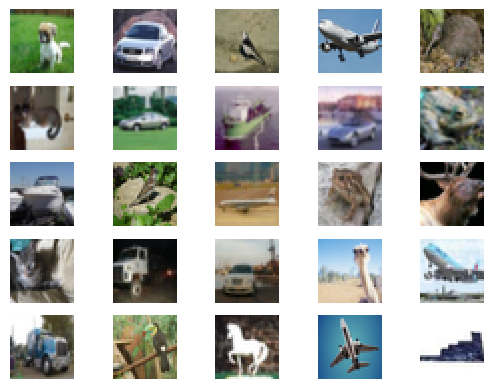

In [ ]:
'''
see what the images in the dataset look like by

plotting 25 random images from the set as a 5x5 plot

these are photographs of planes, trucks, horses, cars, frogs, and so on.
'''

import matplotlib.pyplot as plt
from random import randint

for pic in range(25):
    i = randint(0,50001)
    plt.subplot(5,5,pic+1)
    plt.axis('off')
    plt.imshow(X_train[i])
plt.show()

In [ ]:
'''
implementing the discriminator

|------------------------------------------------------------- D model ------------------------------------------------------------|

       Conv                       Conv                      Conv                Conv             flatten -> Dropout ->       Dense

64 units                        128 units                 128 units             256                                            1
input shape = 32,32,3         strides = 2,2                 2,2                 2,2
kernel = 3,3                   kernel = 3,3                 3,3                 3,3
leaky relu                      leaky relu               leakyrelu            leakyrelu                                     sigmoid

recall what the padding = 'same' does
for a stride of 1,1 (default) the output is the same size as the output
for a stride of 2,2 the ouput dimensions get halved

recall what dropout does :
The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
Inputs not set to 0 are scaled up by 1 / (1 - rate) such that the sum over all inputs is unchanged.

'''

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.optimizers import Adam


def make_D(in_shape = (32,32,3)):
    model = Sequential([
        Conv2D(64, (3,3), padding = 'same', input_shape = in_shape),
        LeakyReLU(alpha = 0.2),
        Conv2D(128, (3,3), strides = (2,2), padding = 'same'),
        LeakyReLU(alpha = 0.2),
        Conv2D(128, (3,3), strides = (2,2), padding = 'same'),
        LeakyReLU(alpha = 0.2),
        Conv2D(256, (3,3), strides = (2,2), padding = 'same'),
        LeakyReLU(alpha = 0.2),
        Flatten(),
        Dropout(0.4),
        Dense(1, activation = 'sigmoid')
    ])

    opt = Adam(learning_rate = 0.0002, beta_1 = 0.5)
    model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         2

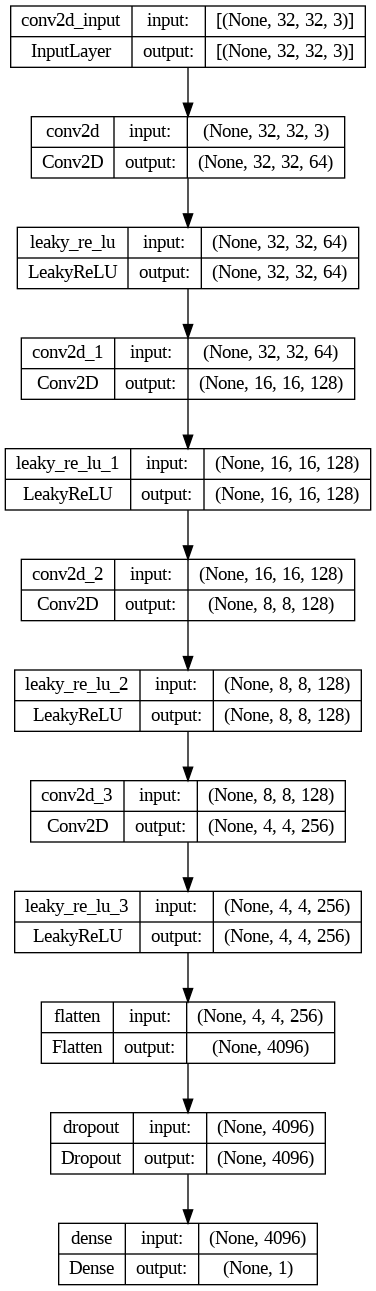

In [ ]:
from keras.utils import plot_model

Dis = make_D()
Dis.summary()
plot_model(Dis, show_layer_names = True, show_shapes = True)

In [ ]:
'''
define load_real_samples() to perform :
    loading of data training input
    normalize values between [-1,1], for this we need set it to float
'''

def load_real_samples():
    (Xt, _), (_, _) = load_data()

    X = Xt.astype('float32')

    X = (X - 127.5) / 127.5

    return X

In [ ]:
'''
define generate_real_samples() to perform :
    selecting random samples from given dataset
    return the samples with a label of 1 (= real)
'''
from numpy.random import randint
from numpy import ones

def generate_real_samples(dataset, n_samples):

    i = randint(0, dataset.shape[0] +1, n_samples)

    X = dataset[i]

    y = ones((n_samples, 1))
    return X, y


In [ ]:
'''
define generate_fake_samples()
'''

from numpy.random import rand
from numpy import zeros

def generate_fake_samples(n_samples):

    i = rand(32 * 32 * 3 * n_samples)

    i = (i * 2) - 1

    X = i.reshape((n_samples, 32, 32, 3))

    y = zeros((n_samples, 1))

    return X, y

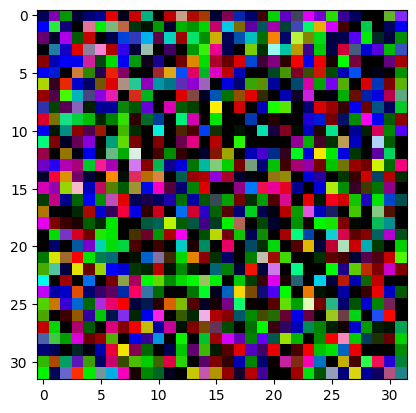

In [ ]:
fake, _ = generate_fake_samples(1)
plt.imshow(fake[0])  # fake has shape (n, 32, 32, 3), we want it to plot one (= first = 0), not n

In [ ]:
'''
define train_D()
'''

def train_D(D, dataset, n_iter = 20, batch_size = 128):
    half_batch = batch_size // 2

    for i in range(n_iter):

        X_real, y_real = generate_real_samples(dataset, half_batch)

        _, acc_real = D.train_on_batch(X_real, y_real)

        X_fake, y_fake = generate_fake_samples(half_batch)

        _, acc_fake = D.train_on_batch(X_fake, y_fake)

        print(f'{i+1}/{n_iter} - Real : {acc_real} - Fake : {acc_fake}')

In [ ]:
Dis = make_D()

dataset = load_real_samples()

train_D(Dis, dataset)

1/20 - Real : 0.609375 - Fake : 0.0
2/20 - Real : 0.953125 - Fake : 0.046875


KeyboardInterrupt: 

In [ ]:
'''
the G :

Dense input -----> Reshape low res -----> C.Trans -----> C.Trans -----> C.Trans -----> Conv out

the dense layer will be used to take input from the latent space
and then use leakyrelu activation for its output

then we reshape this output to put togther low resolution versions of the image : (4, 4, 256) - 256 4x4 imgs  -- (256,4,4) means 256 rows and 4 cols of 4 depth, that not what we want

now it needs to be upsampled. we use ConvTranspose with a kernel of (4,4) and stride of (2,2) (kernel being a multiple of strides is recommended)
the same padding ensure we get the doubled dimensions
this layer can have any units its just common to use powers of 2 ans 128 happens to be half of 256 so were also throwing away useless info

we do is 3 times to get : 4,4 --> 8,8 --> 16,16 --> 32,32

then finally to put all of those feature maps (128 of 32,32) into 1 image of 3 channels,
we use a Conv2D with 3 units and a tanh activation (recall we have normalized color values between -1, 1)
'''

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Reshape
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.utils import plot_model

def make_G(latent_dims):
    model = Sequential([
        Dense(256*4*4, input_dim = latent_dims),
        LeakyReLU(alpha = 0.2),
        Reshape((4, 4, 256)),
        Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same'),
        LeakyReLU(alpha = 0.2),
        Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same'),
        LeakyReLU(alpha = 0.2),
        Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same'),
        LeakyReLU(alpha = 0.2),
        Conv2D(3, (3,3), activation = 'tanh', padding = 'same')
    ])

    return model

In [ ]:
Gen = make_G(100)

Gen.summary()
plot_model(Gen, show_shapes = True)

In [ ]:
'''
make some latent points to test the G
'''

from numpy.random import randn

def generate_latent_points(n_samples, latent_dims):
    x = randn(n_samples * latent_dims)
    x = x.reshape(n_samples, latent_dims)

    return x


In [ ]:
'''
re-define generate_fake_samples()
'''

from numpy.random import rand
from numpy import zeros

def generate_fake_samples(G, n_samples, latent_dim):

    l = generate_latent_points(n_samples, latent_dim)
    X = G.predict(l)
    y = zeros((n_samples, 1))

    return X, y

In [ ]:
import matplotlib.pyplot as plt

L_dim = 100

n_samples = 25

X_fake, y_fake = generate_fake_samples(Gen, n_samples, L_dim)

# print(X_fake.shape) # (25, 32, 32, 3) makes sense right?

for i in range(n_samples):
    plt.subplot(5,5,i+1)
    plt.axis('off')
    plt.imshow(X_fake[i])
plt.show()

In [ ]:
'''define logical GAN model using G and D'''

from keras.optimizers import Adam

def make_GAN(G, D):
    GAN = Sequential()

    D.trainable = False

    GAN.add(G)
    GAN.add(D)

    opt = Adam(learning_rate = 0.0002, beta_1 = 0.5)

    GAN.compile(loss = 'binary_crossentropy', optimizer = opt)

    return GAN


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 32, 32, 3)         1466115   
                                                                 
 sequential_6 (Sequential)   (None, 1)                 522497    
                                                                 
Total params: 1988612 (7.59 MB)
Trainable params: 1466115 (5.59 MB)
Non-trainable params: 522497 (1.99 MB)
_________________________________________________________________


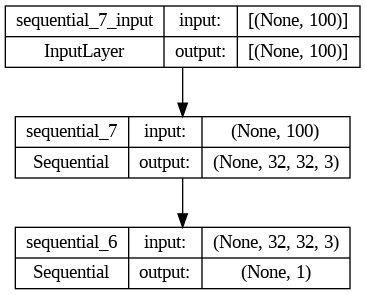

In [ ]:
L_dim = 100
Dis = make_D()
Gen = make_G(L_dim)

gan = make_GAN(Gen, Dis)

gan.summary()
plot_model(gan, show_shapes = True)